In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

returns = pd.read_csv("../data/returns_clean.csv", index_col=0, parse_dates=True)
# Ensure all columns are numeric
returns = returns.apply(pd.to_numeric, errors='coerce')

# Drop any rows or columns that have NaNs after conversion
returns = returns.dropna(axis=1, how='any')  # Remove assets with missing data
returns = returns.dropna(axis=0, how='any')  # Remove dates with missing returns
assets = returns.columns.tolist()

# Confidence level
confidence_level = 0.95

# Portfolio weights (equal for simplicity)
weights = np.array([1/len(assets)] * len(assets))

# Daily portfolio return (dot product of weights × asset returns)
portfolio_return = returns.dot(weights)

# Value at Risk (VaR) at 95% confidence
VaR_95 = np.percentile(portfolio_return, (1 - confidence_level) * 100)
print(f"Portfolio VaR (95%): {VaR_95:.4f}")

Portfolio VaR (95%): -0.0176


In [2]:
portfolio_return = returns.dot(weights)
mu = portfolio_return.mean()
sigma = portfolio_return.std()
z = norm.ppf(1 - confidence_level)
VaR_parametric = -(mu + z * sigma)
print(f"Parametric VaR (Gaussian, 95%): {VaR_parametric:.4f}")


Parametric VaR (Gaussian, 95%): 0.0172


In [3]:
lambda_ = 0.94  # Decay factor
weights_exp = np.array([(1 - lambda_) * lambda_**i for i in range(len(portfolio_return))][::-1])
weights_exp /= weights_exp.sum()

VaR_exp = np.percentile(portfolio_return, (1 - confidence_level) * 100, interpolation='linear')


In [4]:
violations = (portfolio_return < VaR_95).sum()
expected_violations = int((1 - confidence_level) * len(portfolio_return))
print(f"Actual Violations: {violations}, Expected: {expected_violations}")


Actual Violations: 101, Expected: 100


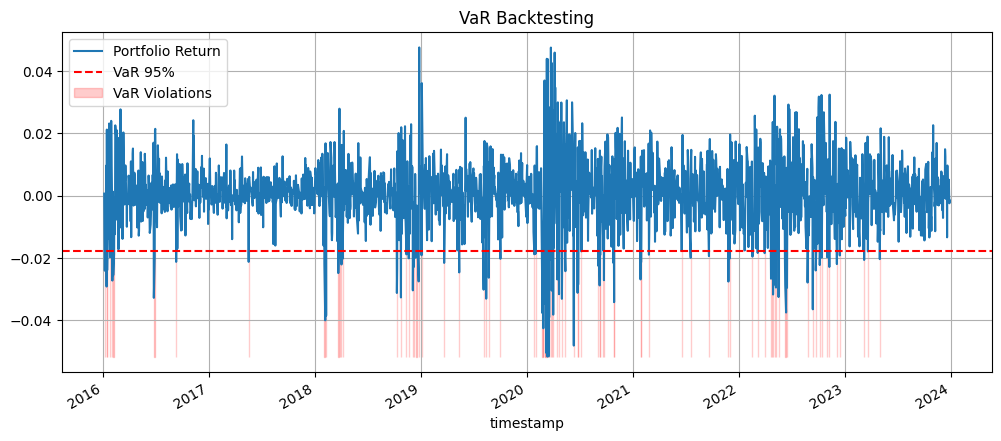

In [5]:
plt.figure(figsize=(12,5))
portfolio_return.plot(label='Portfolio Return')
plt.axhline(VaR_95, color='red', linestyle='--', label='VaR 95%')
plt.fill_between(portfolio_return.index, VaR_95, portfolio_return.min(), 
                 where=portfolio_return < VaR_95, color='red', alpha=0.2, label='VaR Violations')
plt.legend()
plt.title("VaR Backtesting")
plt.grid()
plt.show()


In [6]:
# Expected Shortfall: average of returns worse than the VaR threshold
ES_95 = portfolio_return[portfolio_return <= VaR_95].mean()
print(f"Portfolio Expected Shortfall (CVaR 95%): {ES_95:.4f}")

Portfolio Expected Shortfall (CVaR 95%): -0.0265


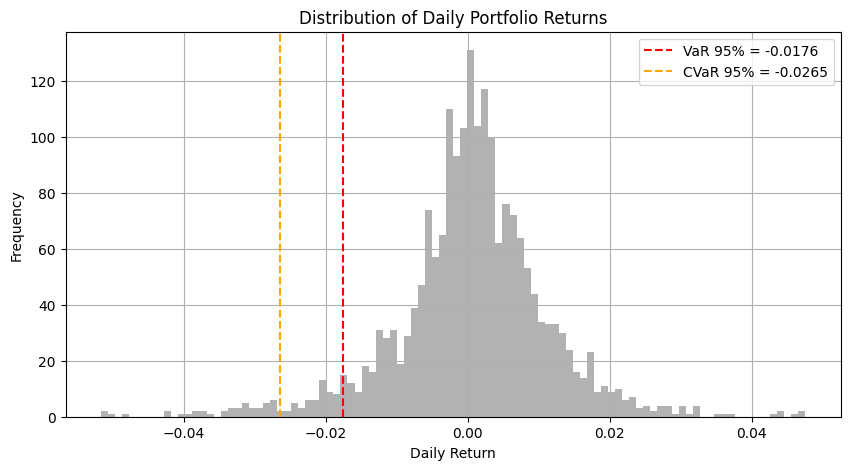

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
portfolio_return.hist(bins=100, alpha=0.6, color='gray')
plt.axvline(VaR_95, color='red', linestyle='--', label=f'VaR 95% = {VaR_95:.4f}')
plt.axvline(ES_95, color='orange', linestyle='--', label=f'CVaR 95% = {ES_95:.4f}')
plt.title("Distribution of Daily Portfolio Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

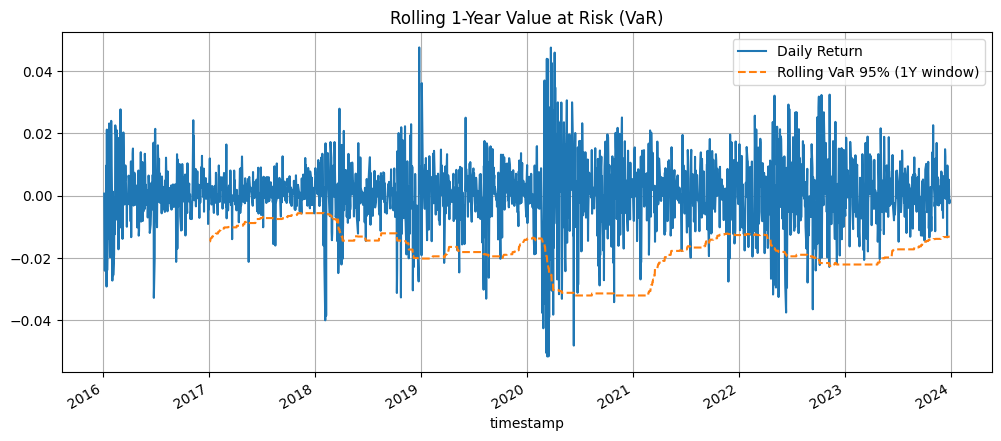

In [8]:
rolling_VaR = portfolio_return.rolling(window=252).quantile(1 - confidence_level)

plt.figure(figsize=(12,5))
portfolio_return.plot(label="Daily Return")
rolling_VaR.plot(label=f"Rolling VaR 95% (1Y window)", linestyle='--')
plt.title("Rolling 1-Year Value at Risk (VaR)")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Monte Carlo simulation for portfolio returns
simulations = np.random.normal(portfolio_return.mean(), portfolio_return.std(), size=10000)

VaR_mc = np.percentile(simulations, (1 - confidence_level) * 100)
ES_mc = simulations[simulations <= VaR_mc].mean()

print(f"Monte Carlo Simulated VaR (95%): {VaR_mc:.4f}")
print(f"Monte Carlo Expected Shortfall (CVaR 95%): {ES_mc:.4f}")



Monte Carlo Simulated VaR (95%): -0.0169
Monte Carlo Expected Shortfall (CVaR 95%): -0.0215


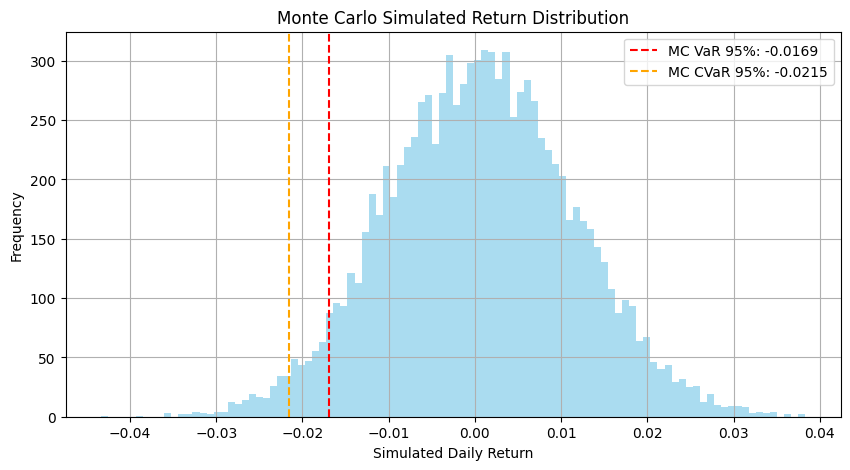

In [10]:
#Visualize Monte Carlo return distribution:

plt.figure(figsize=(10,5))
plt.hist(simulations, bins=100, color='skyblue', alpha=0.7)
plt.axvline(VaR_mc, color='red', linestyle='--', label=f'MC VaR 95%: {VaR_mc:.4f}')
plt.axvline(ES_mc, color='orange', linestyle='--', label=f'MC CVaR 95%: {ES_mc:.4f}')
plt.title("Monte Carlo Simulated Return Distribution")
plt.xlabel("Simulated Daily Return")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
!pip install arch


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
###Volatility Forecasting with GARCH Model
from arch import arch_model

# Scale returns to percentage format
scaled_returns = portfolio_return * 100

# Fit GARCH(1,1)
garch = arch_model(scaled_returns, vol='GARCH', p=1, q=1, dist='t')
garch_fit = garch.fit(disp='off')

# Forecast future volatility for next 5 days
forecast = garch_fit.forecast(horizon=5)
print("Forecasted Variance:")
print(forecast.variance[-1:])

Forecasted Variance:
                                h.1       h.2       h.3       h.4       h.5
timestamp                                                                  
2023-12-29 05:00:00+00:00  0.461384  0.476101  0.490699  0.505179  0.519543


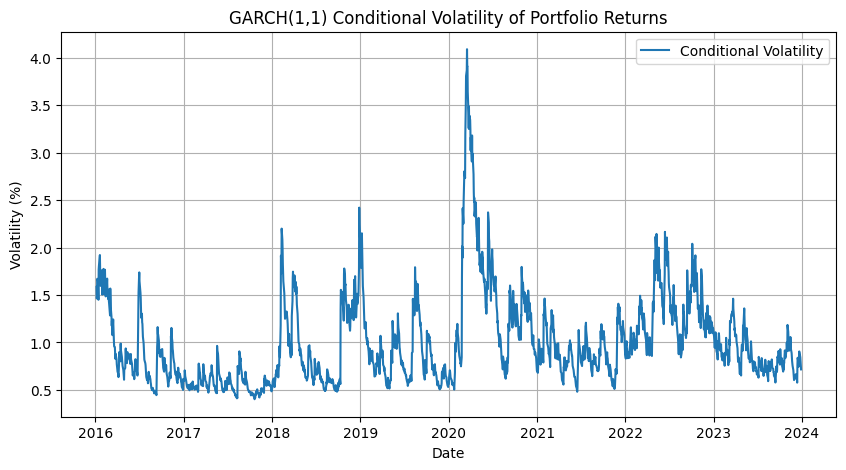

In [13]:
#Plot the conditional volatility:
plt.figure(figsize=(10,5))
plt.plot(garch_fit.conditional_volatility, label='Conditional Volatility')
plt.title("GARCH(1,1) Conditional Volatility of Portfolio Returns")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.grid()
plt.legend()
plt.show()

In [14]:
portfolio_return.to_csv("../data/portfolio_returns.csv", header=['Daily_Return'])


In [15]:
risk_summary = pd.DataFrame({
    "Metric": ["Historical VaR 95%", "Historical CVaR 95%", "Parametric VaR 95%", 
               "MC VaR 95%", "MC CVaR 95%", "Expected Violations", "Actual Violations"],
    "Value": [VaR_95, ES_95, VaR_parametric, VaR_mc, ES_mc, expected_violations, violations]
})
risk_summary.to_csv("../data/risk_summary.csv", index=False)


In [16]:
# ✅ Extract time-aligned rows that violate the VaR threshold
violations_df = portfolio_return[portfolio_return < VaR_95].to_frame(name="Return")

# ✅ Reset index to ensure 'Date' is a column for Power BI
violations_df.reset_index(inplace=True)
violations_df.rename(columns={"index": "Date"}, inplace=True)

# ✅ Save clean and ML-aligned file
violations_df.to_csv("../data/var_violations.csv", index=False)
print("✅ Saved var_violations.csv with correct timestamp and structure.")


✅ Saved var_violations.csv with correct timestamp and structure.


In [17]:
garch_vol_df = pd.DataFrame({
    "Volatility (%)": garch_fit.conditional_volatility
})
garch_vol_df.index = portfolio_return.index  # Ensure date alignment
garch_vol_df.to_csv("../data/garch_volatility.csv")
